# Reconstructing the tropical Pacific SST with PAGES2k and GraphEM

**Expected time to run through: ~0.5 hrs**

In this section, we illustrate the basic workflow of the Graphical Expectation-Maximization algorithm (GraphEM, [Guillot et al., 2015](https://doi.org/10.1214/14-AOAS794)) with `cfr`, conducting a reconstruction experiment with the PAGES2k dataset.
Due to the intensive computational requirement of the GraphEM method, our goal is to reconstruct the air surface temperature field only over the tropical Pacific region using coral records.

Note: `pip install "cfr[graphem]"` to enable the GraphEM method if not done before.

In [1]:
%load_ext autoreload
%autoreload 2

import cfr
print(cfr.__version__)
import numpy as np

0.6.7


## GraphEM steps
### Create a reconstruction job object `cfr.ReconJob` and load the pseudoPAGES2k database

A `cfr.ReconJob` object takes care of the workflow of a reconstruction task.
It provides a series of attributes and methods to help the users go through each step of the reconstruction task, such as loading the proxy database, loading the model prior, calibrating and running the proxy system models, performing the data assimilation solver, etc.

(800.0, 2000.0)

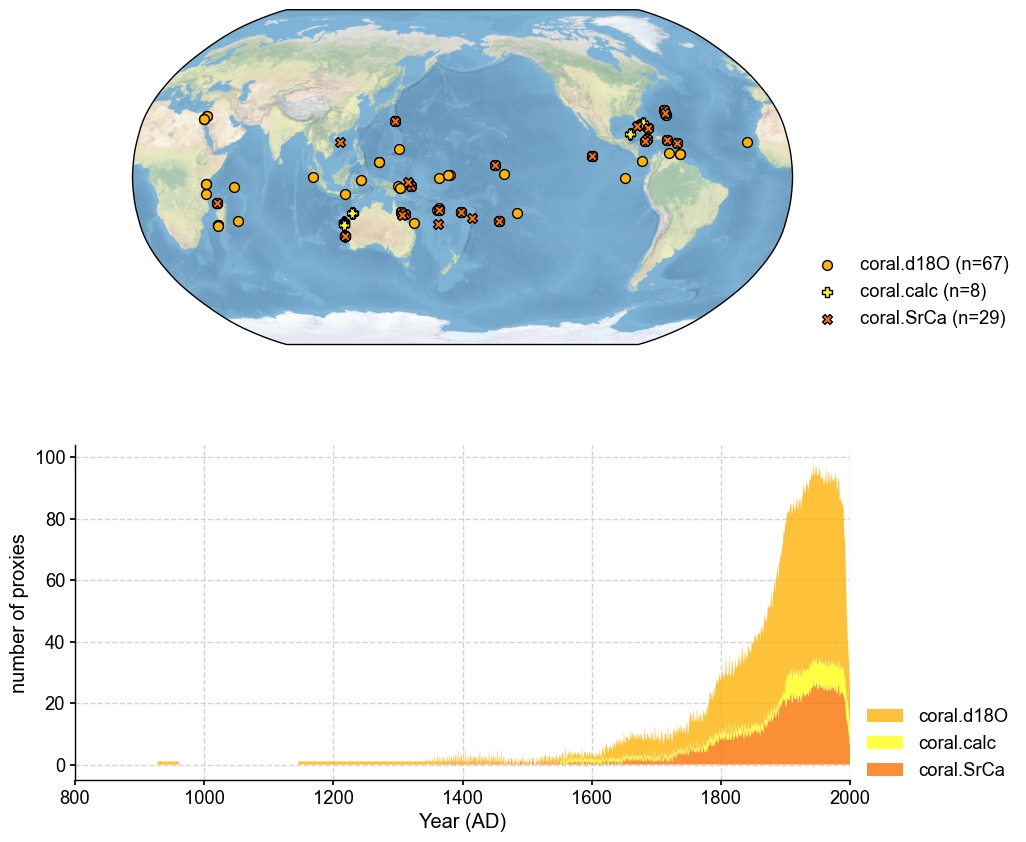

In [2]:
# create a reconstruction job object using the `cfr.ReconJob` class
job = cfr.ReconJob()

# load the pseudoPAGES2k database from a netCDF file

# load from a local copy
# job.proxydb = cfr.ProxyDatabase().load_nc('./data/ppwn_SNRinf_rta.nc')

# load from the cloud
job.load_proxydb('PAGES2kv2')

# filter the database
job.filter_proxydb(by='ptype', keys='coral')

# plot to have a check of the database
fig, ax = job.proxydb.plot(plot_count=True)
ax['count'].set_xlim(800, 2000)

### Annualize each proxy record

In [3]:
job.annualize_proxydb(months=[12, 1, 2], verbose=True)

>>> job.configs["annualize_proxydb_months"] = [12, 1, 2]
>>> job.configs["annualize_proxydb_ptypes"] = {'coral.d18O', 'coral.calc', 'coral.SrCa'}


Annualizing ProxyDatabase: 100%|██████████| 104/104 [00:02<00:00, 43.65it/s]

>>> 99 records remaining
>>> job.proxydb updated


### Load the instrumental observations

As a perfect model prior pseudoproxy experiment (PPE), we use the iCESM simulated fields as instrumental observations.

In [4]:
job.load_clim(
    tag='obs',
    path_dict={
        'tas': 'gistemp1200_GHCNv4_ERSSTv5', # load from the cloud
    },
    rename_dict={'tas': 'tempanomaly'},
    anom_period=(1951, 1980),
    load=True,  # load the data into memeory to accelerate the later access; requires large memeory
    verbose=True,
)

>>> job.configs["obs_path"] = {'tas': 'gistemp1200_GHCNv4_ERSSTv5'}
>>> job.configs["obs_rename_dict"] = {'tas': 'tempanomaly'}
>>> job.configs["obs_anom_period"] = [1951, 1980]
>>> job.configs["obs_lat_name"] = lat
>>> job.configs["obs_lon_name"] = lon
>>> job.configs["obs_time_name"] = time
>>> The target file seems existed at: ./data/gistemp1200_GHCNv4_ERSSTv5.nc.gz . Loading from it instead of downloading ...
>>> obs variables ['tas'] loaded
>>> job.obs created


### Annualize the observation fields

This step will determine the temporal resolution of the reconstructed fields.

In [5]:
job.annualize_clim(tag='obs', verbose=True, months=[12, 1, 2])

>>> job.configs["obs_annualize_months"] = [12, 1, 2]
>>> Processing tas ...
>>> job.obs updated


### Regrid the observation fields

This step will determine the spatial resolution of the reconstructed fields.

In [6]:
job.regrid_clim(tag='obs', nlat=42, nlon=63, verbose=True)

>>> job.configs["obs_regrid_nlat"] = 42
>>> job.configs["obs_regrid_nlon"] = 63
>>> Processing tas ...


### Crop the observations fields to make the problem size smaller

In [7]:
job.crop_clim(tag='obs', lat_min=-20, lat_max=20, lon_min=150, lon_max=260, verbose=True)

>>> job.configs["obs_lat_min"] = -20
>>> job.configs["obs_lat_max"] = 20
>>> job.configs["obs_lon_min"] = 150
>>> job.configs["obs_lon_max"] = 260
>>> Processing tas ...


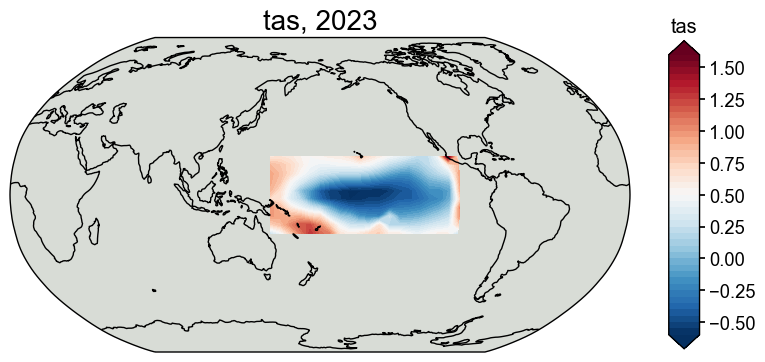

In [8]:
# check the cropped domain
fig, ax = job.obs['tas'][-1].plot()

### (Optional) Save the job object for later reload

Save the job object before running the DA procedure for a quick reload next time if needed.

In [9]:
job.save('./cases/graphem-real-pages2k', verbose=True)

>>> job.configs["save_dirpath"] = ./cases/graphem-real-pages2k
>>> obs_tas saved to: ./cases/graphem-real-pages2k/obs_tas.nc
>>> job saved to: ./cases/graphem-real-pages2k/job.pkl


Now let's reload the job object from the saved directory.

In [10]:
job = cfr.ReconJob()
job.load('./cases/graphem-real-pages2k/', verbose=True)

>>> job is loaded
>>> job.obs["tas"].da is loaded


### Prepare the GraphEM solver

In [11]:
job.prep_graphem(
    recon_period=(1871, 2000),  # period to reconstruct
    calib_period=(1901, 2000),  # period for calibration
    uniform_pdb=True,           # filter the proxydb to be more uniform
    verbose=True,
)

>>> job.configs["recon_period"] = [1871, 2000]
>>> job.configs["recon_timescale"] = 1
>>> job.configs["calib_period"] = [1901, 2000]
>>> job.configs["uniform_pdb"] = True
>>> ProxyDatabase filtered to be more uniform. 54 records remaining.
>>> job.configs["proxydb_center_ref_period"] = [1901, 2000]


Centering each of the ProxyRecord: 100%|██████████| 54/54 [00:00<00:00, 1825.12it/s]

>>> job.proxydb updated
>>> job.graphem_params["recon_time"] created
>>> job.graphem_params["calib_time"] created


>>> job.graphem_params["field_obs"] created
>>> job.graphem_params["calib_idx"] created
>>> job.graphem_params["field"] created
>>> job.graphem_params["df_proxy"] created
>>> job.graphem_params["proxy"] created
>>> job.graphem_params["lonlat"] created


### Run the GraphEM solver

We will take the Empirical Graphs (graphical lasso, `glasso`) approach.

In [12]:
job.run_graphem(
    save_dirpath='./recons/graphem-real-pages2k',
    graph_method='hybrid',
    cutoff_radius=1500,
    sp_FF=3, sp_FP=4,
    verbose=True,
)

>>> job.configs["compress_params"] = {'zlib': True}
>>> job.configs["save_dirpath"] = ./recons/graphem-real-pages2k
>>> job.configs["save_filename"] = job_r01_recon.nc
>>> job.configs["graph_method"] = hybrid
>>> job.configs["cutoff_radius"] = 1500
>>> job.configs["sp_FF"] = 3
>>> job.configs["sp_FP"] = 4
Computing a neighborhood graph with R = 1500.0 km
Estimating graph using neighborhood method
Running GraphEM:



EM | dXmis: 0.0026; rdXmis: 0.0046:   4%|▍         | 9/200 [03:14<1:08:52, 21.63s/it]


GraphEM.EM(): Tolerance achieved.
Solving graphical LASSO using greedy search


graph_greedy_search | FF:  3.720; FP:  3.644; PP:  0.000:   3%|▎         | 17/500 [00:01<00:39, 12.37it/s]


Using specified graph
Running GraphEM:



EM | dXmis: 0.0021; rdXmis: 0.0049:   8%|▊         | 15/200 [05:23<1:06:26, 21.55s/it]

GraphEM.EM(): Tolerance achieved.
job.graphem_solver created and saved to: None
>>> job.recon_fields created
>>> Reconstructed fields saved to: ./recons/graphem-real-pages2k/job_r01_recon.nc


## Validation steps

### Create the reconstruction result object `cfr.ReconRes`.

A `cfr.ReconRes` object takes care of the workflow of postprocessing and analyzing the reconstruction results.
It provides handy methods to help the users load, validate, and visualize the reconstruction results.

In [13]:
res = cfr.ReconRes('./recons/graphem-real-pages2k', verbose=True)

>>> res.paths:
['./recons/graphem-real-pages2k/job_r01_recon.nc']


### Load the reconstructed variables

Here we validate the `tas` field and the NINO3.4 index as an example.

In [14]:
res.load(['tas', 'nino3.4'], verbose=True)

>>> ReconRes.recons["tas"] created
>>> ReconRes.da["tas"] created
>>> ReconRes.recons["nino3.4"] created
>>> ReconRes.da["nino3.4"] created


### Validate the reconstructed NINO3.4

We calculate the annualized NINO3.4 from Bunge & Clarke (2009) as a reference for validation.

In [15]:
bc09 = cfr.EnsTS().fetch('BC09_NINO34').annualize(months=[12, 1, 2])

We use a chain calling of several methods, including the validation step `.validate()` and the plotting step `.plot_qs()`.

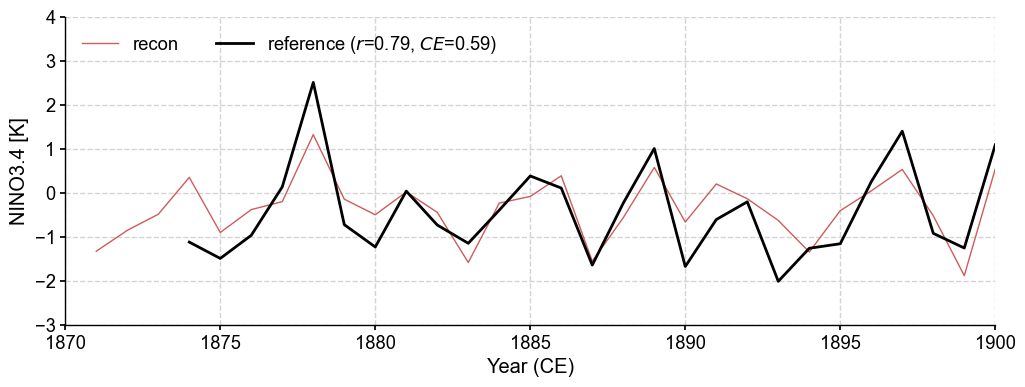

Figure saved at: "figs/graphem_corr_recon_BC09.pdf"


In [52]:
fig, ax = res.recons['nino3.4'].compare(bc09, timespan=(1874, 1900)).plot(label='recon')
ax.set_xlim(1870, 1900)
ax.set_ylim(-3, 4)
ax.set_ylabel('NINO3.4 [K]')
cfr.showfig(fig)
cfr.savefig(fig, f'./figs/graphem_corr_recon_BC09.pdf')

### Validate the reconstructed fields

In [17]:
target = cfr.ClimateField().fetch('20CRv3/tas', vn='air').rename('tas').get_anom((1951, 1980)).annualize(months=[12, 1, 2])

>>> The target file seems existed at: ./data/air.2m.mon.mean.nc . Loading from it instead of downloading ...


Calculating and visualizing the correlation coefficient ($r$) between the reconstructed and target fields, we see overall high skills.

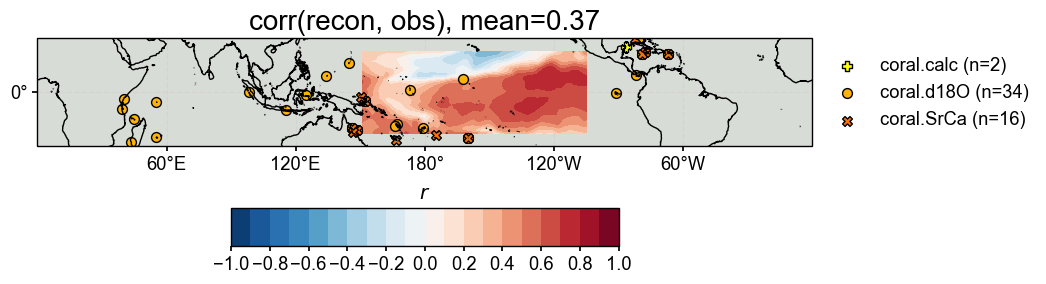

Figure saved at: "figs/graphem_corr_recon_obs.pdf"


In [91]:
# validate the reconstruction against 20CR
stat = 'corr'

valid_fd = res.recons['tas'].compare(
    target, stat=stat, 
    timespan=(1874, 1900),
)
valid_fd.plot_kwargs.update({'cbar_orientation': 'horizontal', 'cbar_pad': 0.1})

fig, ax = valid_fd.plot(
    title=f'{stat}(recon, obs), mean={valid_fd.geo_mean().value[0,0]:.2f}',
    projection='PlateCarree',
    latlon_range=(-25, 25, 0, 360),
    # latlon_range=(-20, 20, 150, 256),
    plot_cbar=True,
    plot_proxydb=True, proxydb=job.proxydb,
    proxydb_lgd_kws={'loc': 'lower left', 'bbox_to_anchor': (1, 0)},
)

cfr.showfig(fig)
cfr.savefig(fig, f'./figs/graphem_{stat}_recon_obs.pdf')

## Comparison to the LMR/PDA based reconstruction

In [22]:
res_lmr = cfr.ReconRes('./recons/lmr-real-pages2k', verbose=True)
res_graphem = cfr.ReconRes('./recons/graphem-real-pages2k', verbose=True)

>>> res.paths:
['./recons/lmr-real-pages2k/job_r01_recon.nc', './recons/lmr-real-pages2k/job_r02_recon.nc', './recons/lmr-real-pages2k/job_r03_recon.nc', './recons/lmr-real-pages2k/job_r04_recon.nc', './recons/lmr-real-pages2k/job_r05_recon.nc', './recons/lmr-real-pages2k/job_r06_recon.nc', './recons/lmr-real-pages2k/job_r07_recon.nc', './recons/lmr-real-pages2k/job_r08_recon.nc', './recons/lmr-real-pages2k/job_r09_recon.nc', './recons/lmr-real-pages2k/job_r10_recon.nc']
>>> res.paths:
['./recons/graphem-real-pages2k/job_r01_recon.nc']


In [49]:
tas_20CRv3 = cfr.ClimateField().fetch('20CRv3/tas', vn='air').rename('tas').get_anom((1951, 1980)).annualize(months=[12, 1, 2])
tas_20CRv3 = tas_20CRv3.crop(lat_min=-20, lat_max=20, lon_min=150, lon_max=260)
nino34_bc09 = cfr.EnsTS().fetch('BC09_NINO34').annualize(months=[12, 1, 2])

>>> The target file seems existed at: ./data/air.2m.mon.mean.nc . Loading from it instead of downloading ...


In [73]:
res_graphem.valid(
    target_dict={'tas':  tas_20CRv3, 'nino3.4': nino34_bc09},
    timespan=(1874, 1900), verbose=True,
    stat=['corr', 'CE'],
)

>>> ReconRes.recons["tas"] created
>>> ReconRes.da["tas"] created
>>> ReconRes.recons["nino3.4"] created
>>> ReconRes.da["nino3.4"] created
>>> Validating variable: tas ...
>>> ReconRes.valid_fd[tas_corr] created
>>> ReconRes.valid_fd[tas_CE] created
>>> Validating variable: nino3.4 ...
>>> ReconRes.valid_ts[nino3.4] created


In [79]:
res_lmr.valid(
    target_dict={'tas':  tas_20CRv3, 'nino3.4': nino34_bc09},
    timespan=(1874, 1900), verbose=True,
    stat=['corr', 'CE'],
)

>>> ReconRes.recons["tas"] created
>>> ReconRes.da["tas"] created
>>> ReconRes.recons["nino3.4"] created
>>> ReconRes.da["nino3.4"] created
>>> Validating variable: tas ...
>>> ReconRes.valid_fd[tas_corr] created
>>> ReconRes.valid_fd[tas_CE] created
>>> Validating variable: nino3.4 ...
>>> ReconRes.valid_ts[nino3.4] created


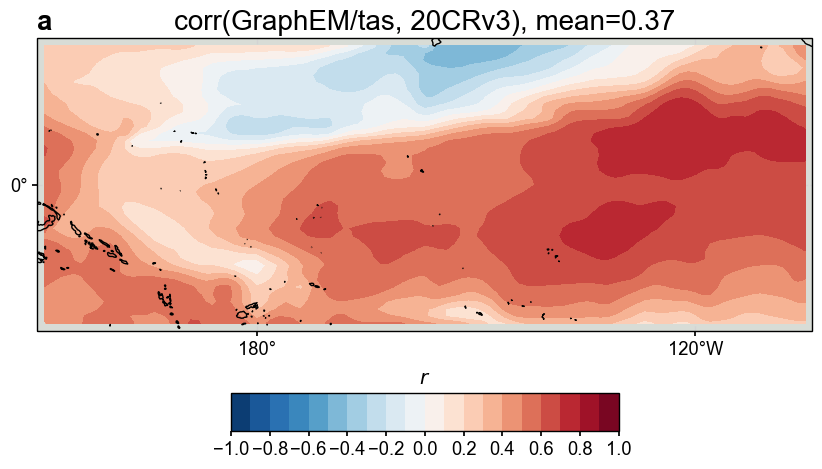

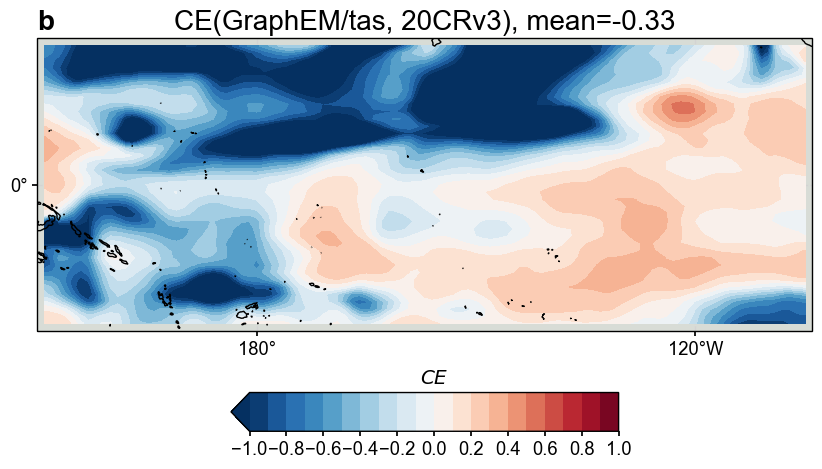

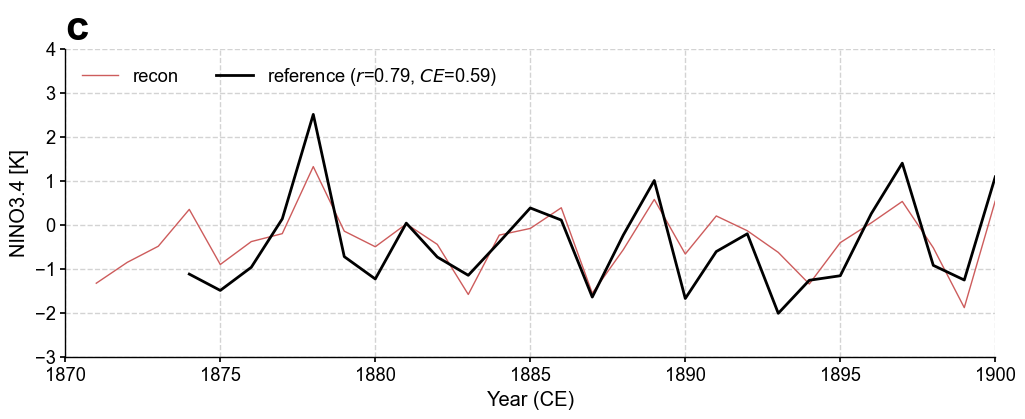

Figure saved at: "figs/graphem_tas_corr.pdf"
Figure saved at: "figs/graphem_tas_CE.pdf"
Figure saved at: "figs/graphem_nino3.4.pdf"


In [100]:
fig, ax = res_graphem.plot_valid(
    target_name_dict={'tas': '20CRv3', 'nino3.4': 'BC09'},
    recon_name_dict={'tas': 'GraphEM/tas', 'nino3.4': 'NINO3.4 [K]'},
    valid_fd_kws=dict(
        projection='PlateCarree',
        latlon_range=(-20, 20, 150, 256),
        plot_cbar=True,
    ),
    valid_ts_kws=dict(
        xlim = (1870, 1900),
        ylim = (-3, 4),
    )
)

cfr.visual.add_annotation(ax, fs=[20, 20, 30])

for k, v in fig.items():
    cfr.showfig(v)
    cfr.savefig(v, f'./figs/graphem_{k}.pdf')
    

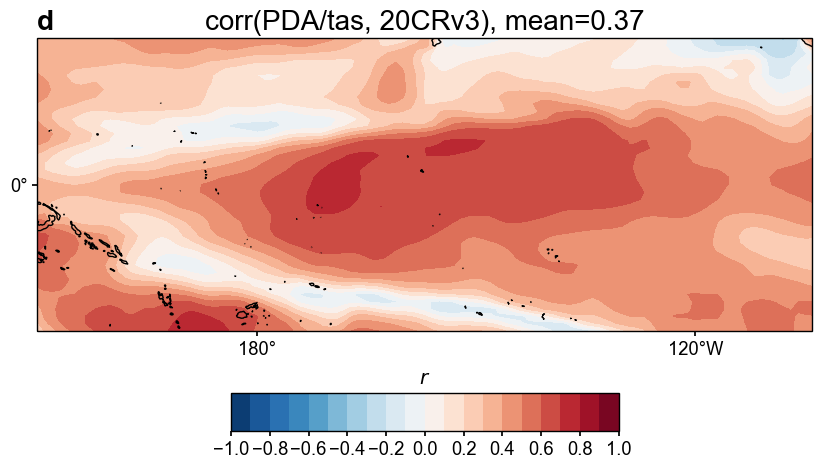

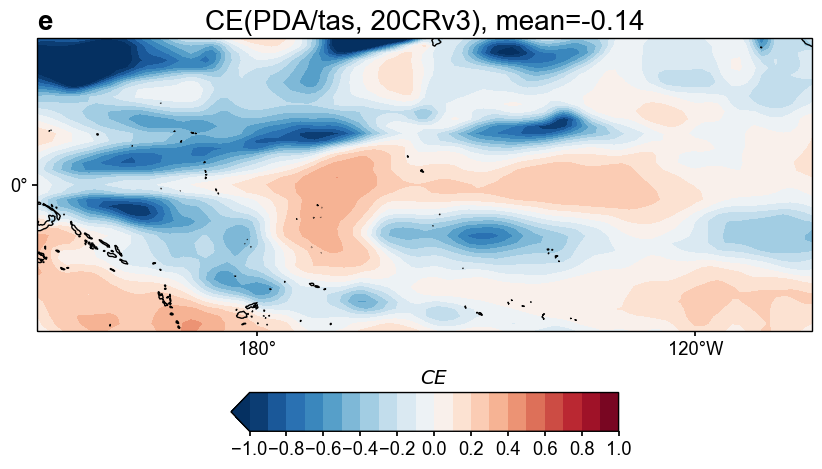

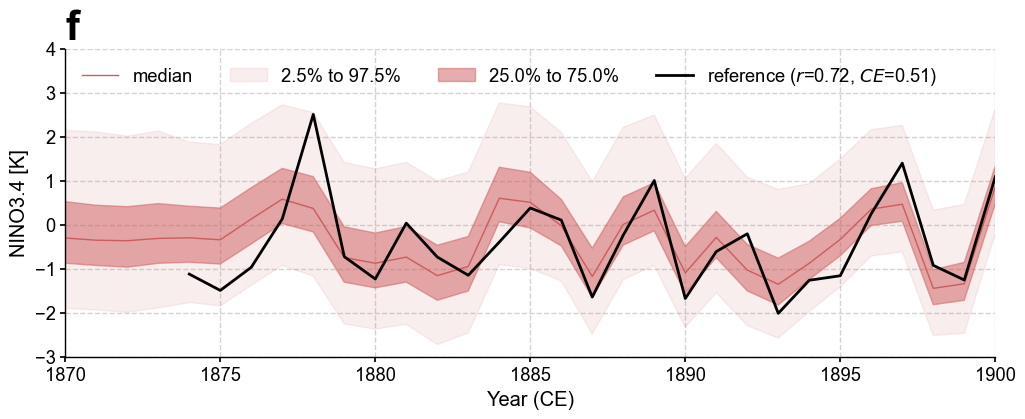

Figure saved at: "figs/lmr_tas_corr.pdf"
Figure saved at: "figs/lmr_tas_CE.pdf"
Figure saved at: "figs/lmr_nino3.4.pdf"


In [105]:
fig, ax = res_lmr.plot_valid(
    target_name_dict={'tas': '20CRv3', 'nino3.4': 'BC09'},
    recon_name_dict={'tas': 'PDA/tas', 'nino3.4': 'NINO3.4 [K]'},
    valid_fd_kws=dict(
        projection='PlateCarree',
        latlon_range=(-20, 20, 150, 256),
        plot_cbar=True,
    ),
    valid_ts_kws=dict(
        xlim = (1870, 1900),
        ylim = (-3, 4),
    )
)

cfr.visual.add_annotation(ax, fs=[20, 20, 30], start=3)

for k, v in fig.items():
    cfr.showfig(v)
    cfr.savefig(v, f'./figs/lmr_{k}.pdf')